## MSE Results
This notebook displays the results of running the SpaceGraph method using MSE scores for graph comparison

In [1]:
"""Imports and settings"""
from spacegraph.load import load_data,load_anom,load_learned_structures,load_labels
from spacegraph.structurelearn import learn_dynotears
from spacegraph.compare import mse_compare, anomrank_compare
from spacegraph.detect import thresh_and_prune
from spacegraph.visualize import plot_detected
from spacegraph.metrics import calc_confusion, calc_precision,calc_recall,calc_f1
from spacegraph.config import SAVED_PATH, SAVED_VERSION
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0})

%load_ext autoreload
%autoreload 2

tp, fp, fn, tn: [19, 11, 18, 6]
precision: 0.633
recall: 0.514
F1: 0.567


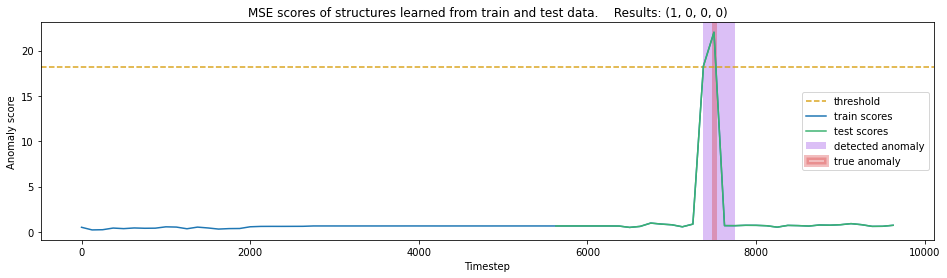

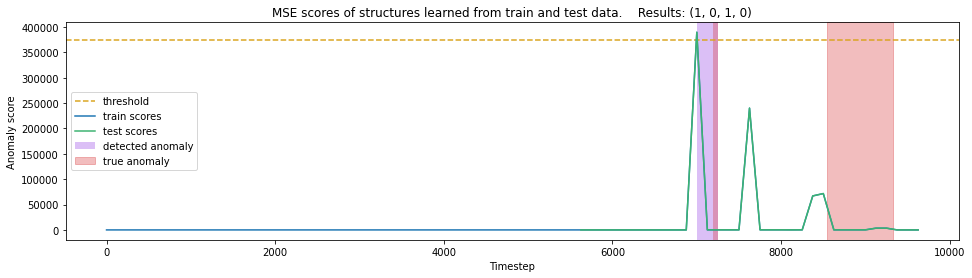

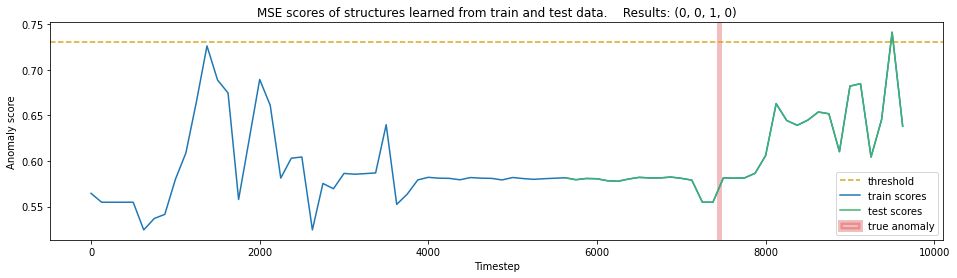

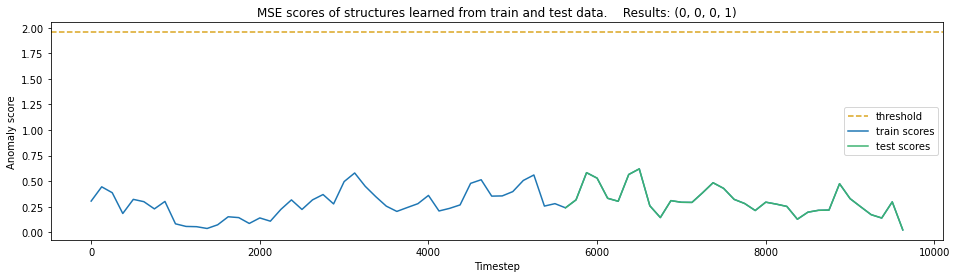

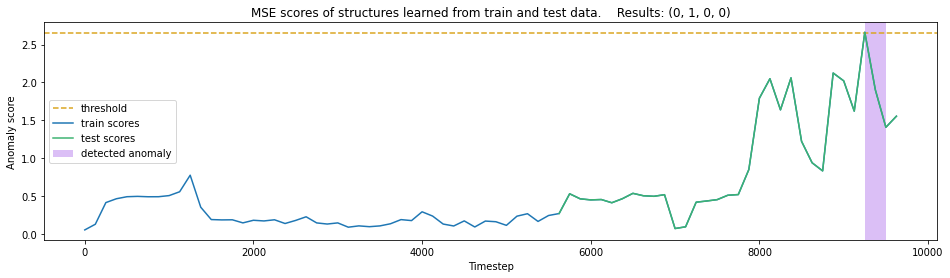

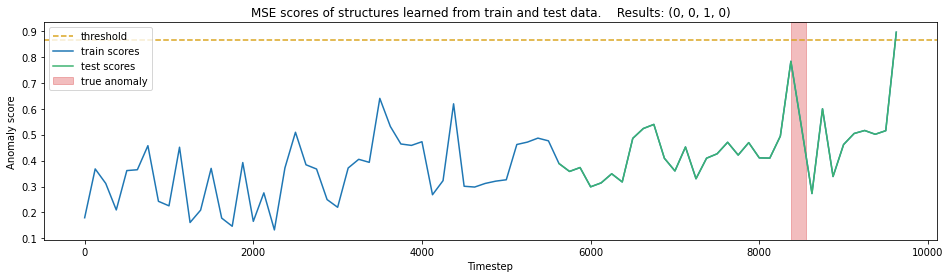

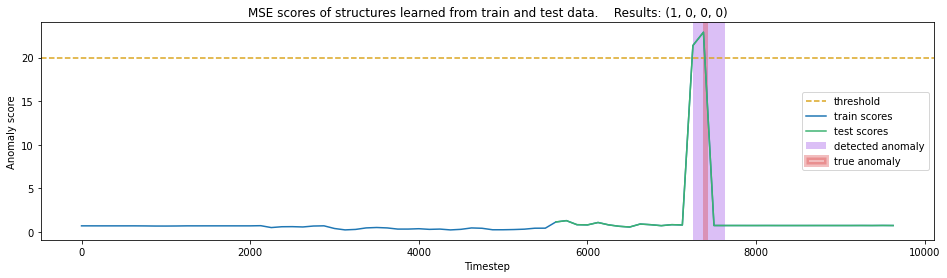

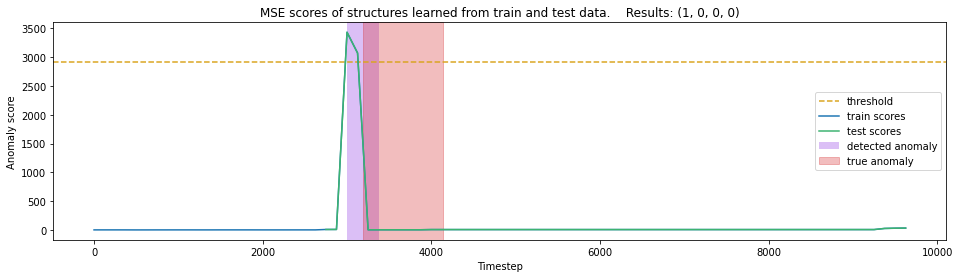

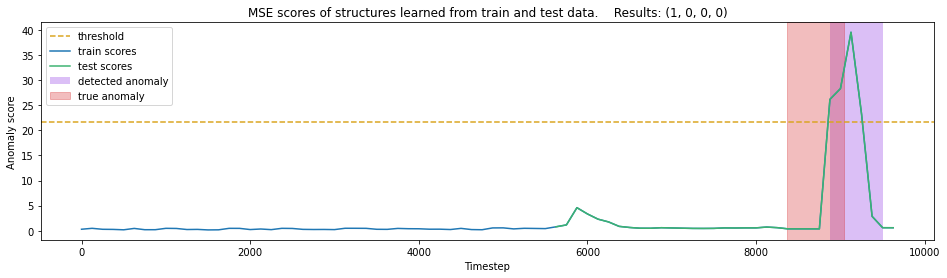

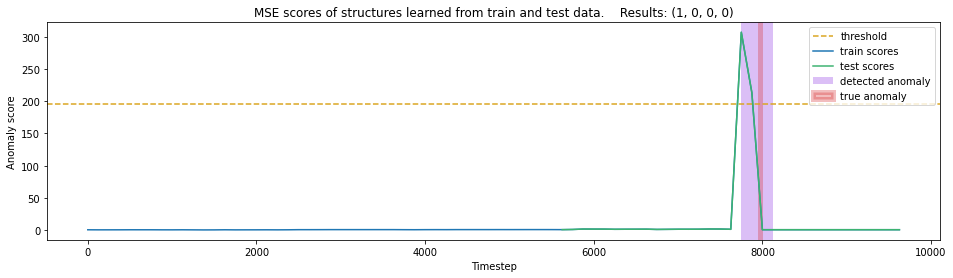

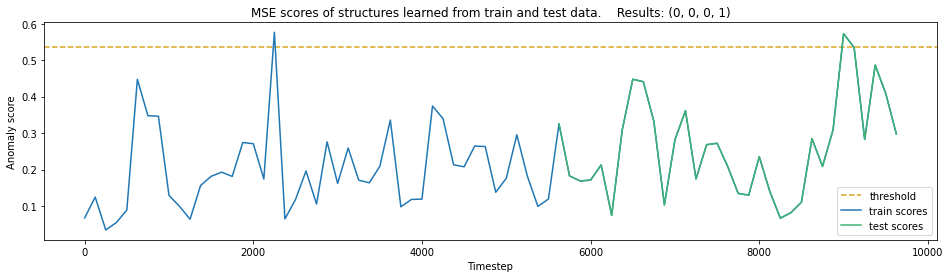

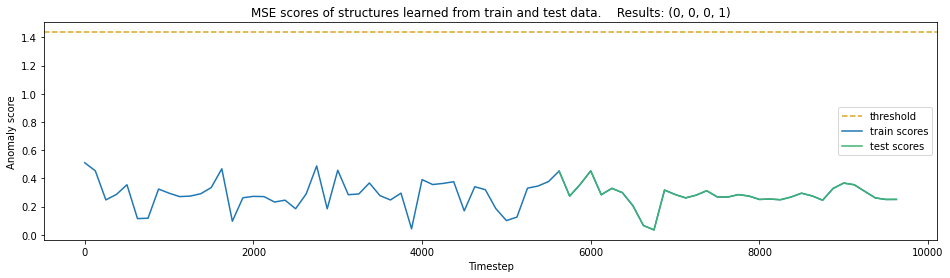

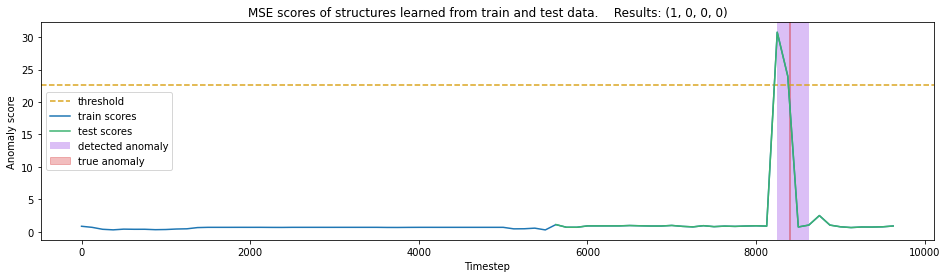

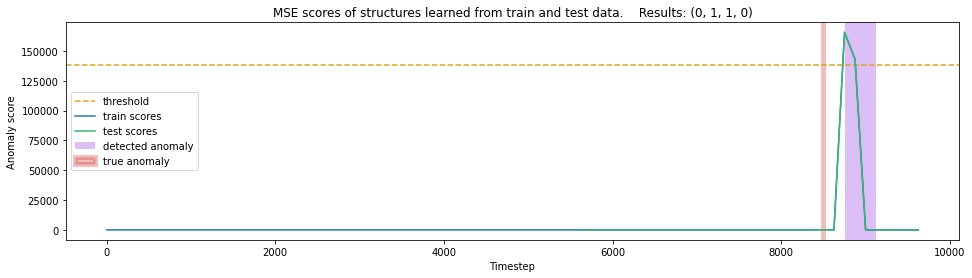

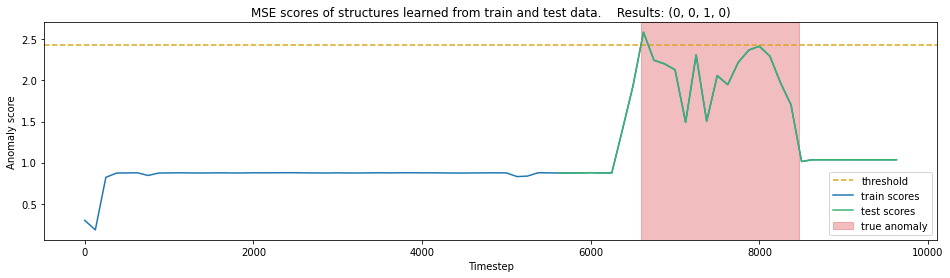

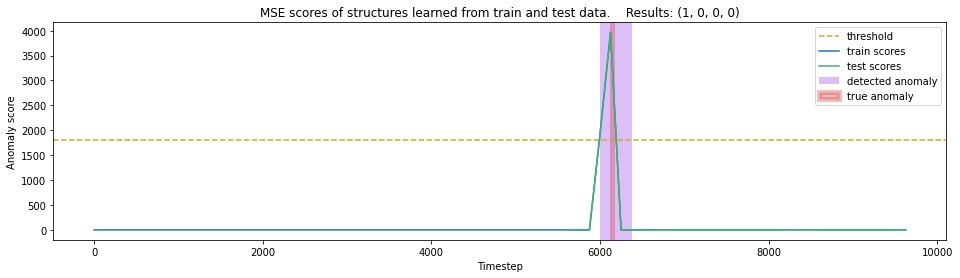

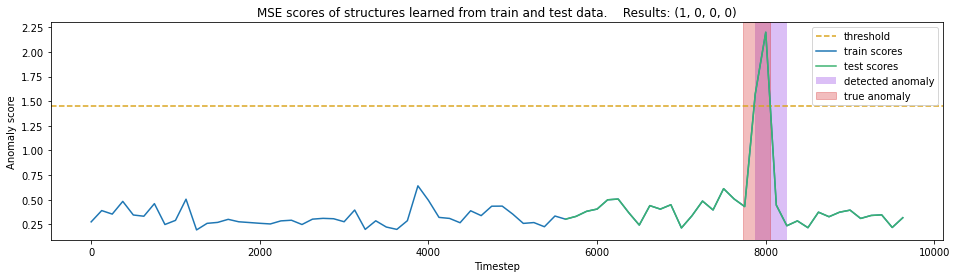

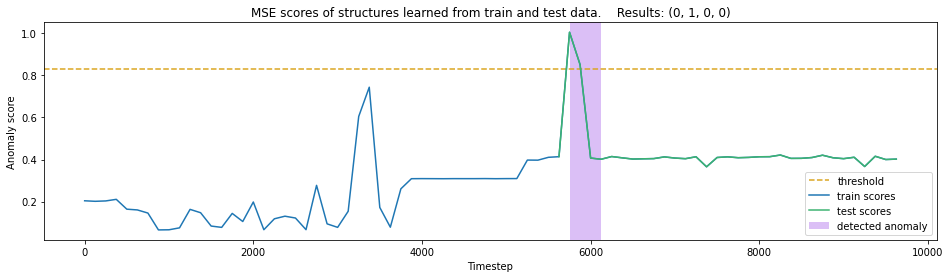

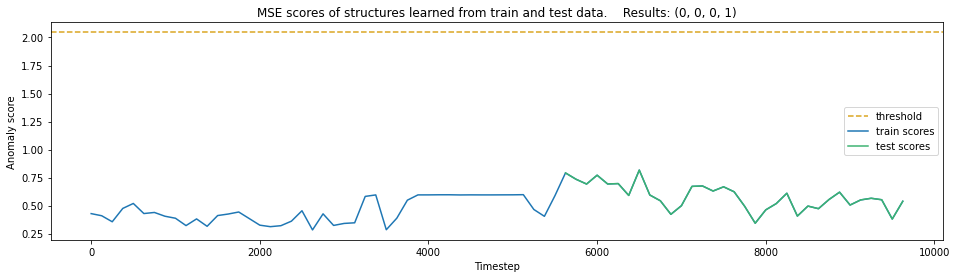

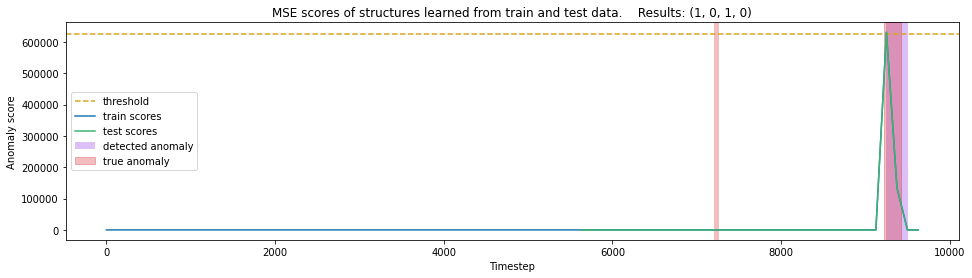

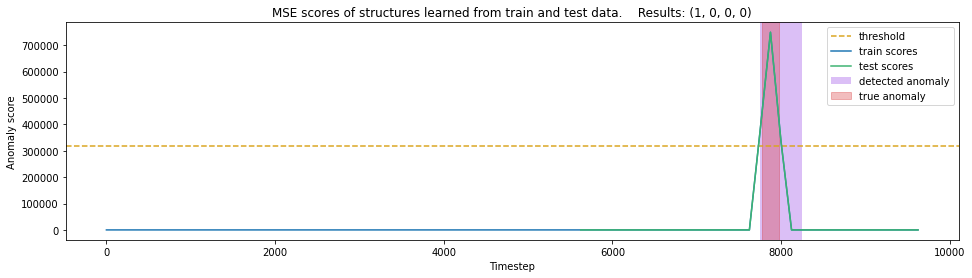

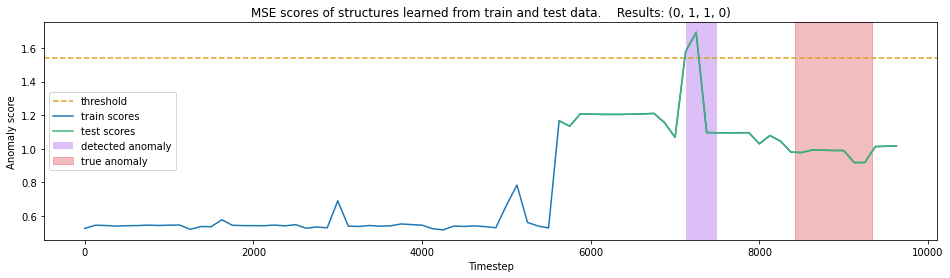

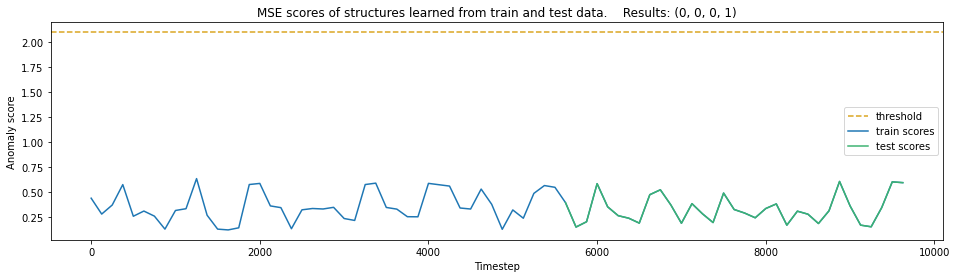

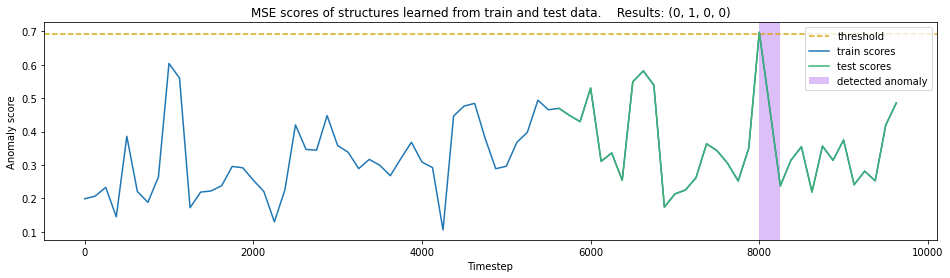

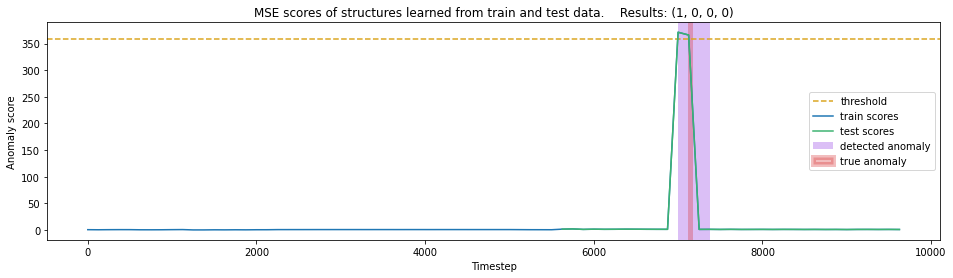

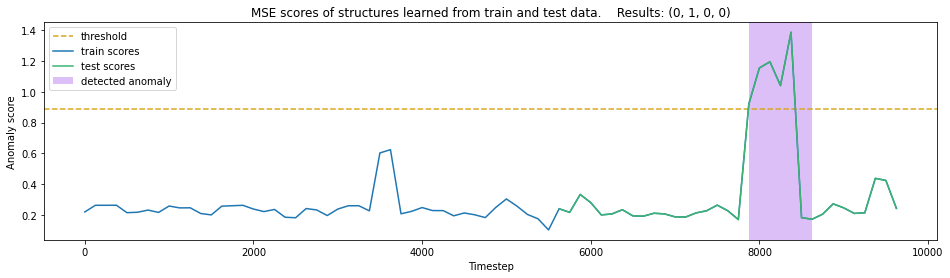

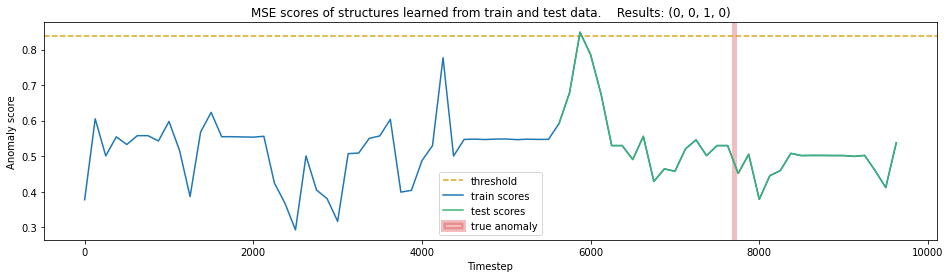

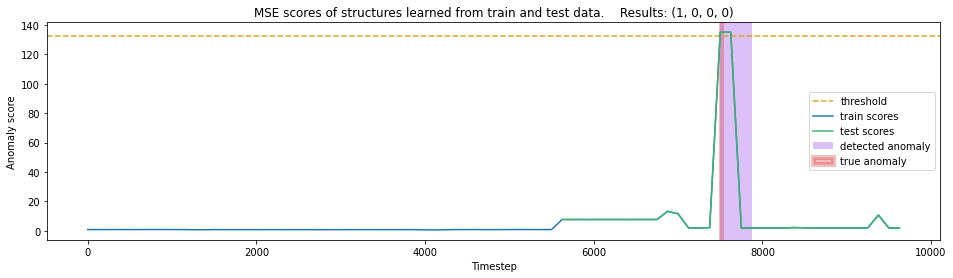

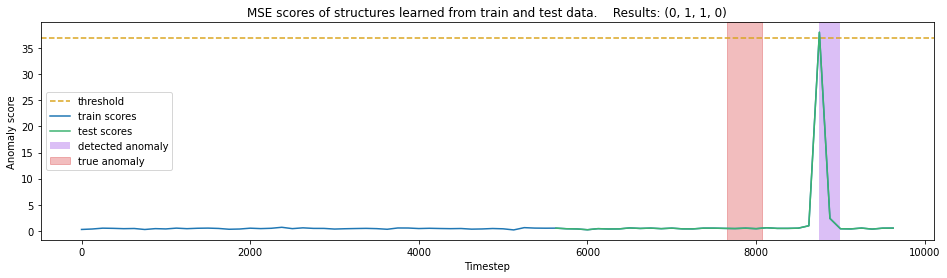

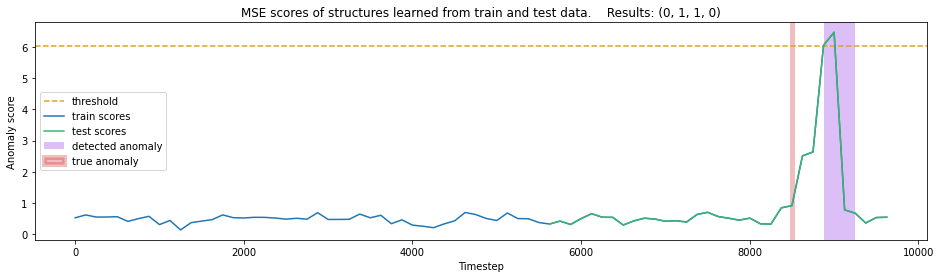

In [4]:
"""Results for all channels"""
pd_labels = load_labels(verbose=False) # get anomaly labels
all_confusion = [] # store confusion matrices

for _,label_row in pd_labels.iterrows(): # iterate through labels
    pid = label_row['pid']
    saf = label_row['saf']
    true_anom = pd.eval(label_row['anom_window'])

    # load train/test data pandas data
    pd_train,pd_test = load_data(saf,pid,verbose=False)

    # load saved graph structures if they exist
    saved_path = os.path.join(SAVED_PATH, SAVED_VERSION, f'adj-{pid}-{saf}.npz')
    adj_data = load_learned_structures(saved_path)
    if adj_data == False: # learn graph structures if no saved data found
        print(f"Learning dynotears structures for SAF {saf}")
        adj_base = learn_dynotears(pd_train,stride=0, window_len=0, force_dag=True, verbose=False)
        all_adj_train = learn_dynotears(pd_train, force_dag=True, verbose=False)
        all_adj_test = learn_dynotears(pd_test, force_dag=True, verbose=False)
        np.savez(saved_path, adj_base=adj_base, all_adj_train=all_adj_train, all_adj_test=all_adj_test)
    else:
        adj_base = adj_data['adj_base']
        all_adj_train = adj_data['all_adj_train']
        all_adj_test = adj_data['all_adj_test']

    # compare graph structures
    mse_train,mse_test,max_channel = mse_compare(adj_base,all_adj_train, all_adj_test)

    # apply thresholding and pruning
    predicted_anom, epsilon = thresh_and_prune(mse_test, train_err=mse_train, verbose=False)

    # record metrics
    confusion = calc_confusion(predicted_anom,true_anom)
    all_confusion.append(confusion)

    # plot true and predicted anomalies of each SAF
    plot_detected(predicted_anom,true_anom,mse_test, mse_train, epsilon, f'MSE scores of structures learned from train and test data.    Results: {confusion}')
    # plot_detected(predicted_anom,true_anom,mse_test, mse_train, epsilon, f'MSE scores of structures learned from train and test data.    PID: {pid}, SAF: {saf}.     Results: {confusion}.   Max channel: {pd_train.columns[max_channel]}')

# Print overall results
sum_confusion = np.sum(np.array(all_confusion),axis=0).tolist()
print(f'tp, fp, fn, tn: {sum_confusion}')
print(f'precision: {calc_precision(sum_confusion):.3f}')
print(f'recall: {calc_recall(sum_confusion):.3f}')
print(f'F1: {calc_f1(sum_confusion):.3f}')